In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
interactions_from_selected_users_df=pd.read_csv('triplets5.csv')

# popular songs are liked more

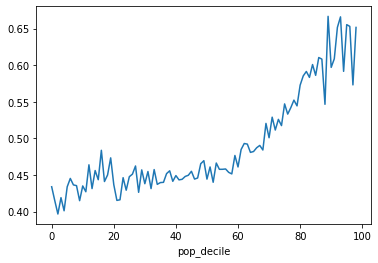

In [3]:
interactions_from_selected_users_df.groupby(['pop_decile']).mean()['liked'].plot()

# popularity of rated songs is normally distributed

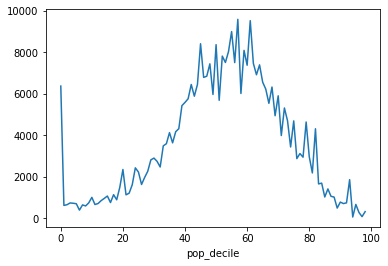

In [166]:
interactions_from_selected_users_df.groupby(['pop_decile']).count()['liked'].plot()

# Split into training and testing set

In [4]:
train_df, test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['user_id'], 
                                   test_size=0.20)
print('# interactions on Train set: %d' % len(train_df))
print('# interactions on Test set: %d' % len(test_df))

# interactions on Train set: 284054
# interactions on Test set: 71014


In [158]:
interactions_test_indexed_df = test_df.set_index('user_id')
class ModelEvaluator:

    def evaluate_model_for_user(self, model, user_id):

        user_likes_df=test_df[test_df['user_id']==user_id][['liked','song_id','pop_decile']].set_index('song_id').sort_index()['liked']

        song_list=test_df[test_df['user_id']==user_id].set_index('song_id')['pop_decile'].sort_index()
        user_recs_df = model.classify_items(user_id,song_list).sort_index()

        kappa=metrics.cohen_kappa_score(user_likes_df,user_recs_df)
        accuracy_score=metrics.accuracy_score(user_likes_df,user_recs_df)

        if (sum(user_likes_df==1)>0) & (sum(user_recs_df==1)>0):
            model_pop=song_list[user_recs_df==1].mean() 
            my_pop=song_list[user_likes_df==1].mean()
            pop_bias=model_pop-my_pop
        else:
            pop_bias=0

        user_metrics = {'accuracy':accuracy_score,'kappa':kappa, 'popularity_bias':pop_bias}
        return user_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            people_metrics.append(person_metrics)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('accuracy', ascending=False)
        
        global_accuracy= detailed_results_df['accuracy'].sum() / float(detailed_results_df['accuracy'].count())
        global_kappa= detailed_results_df['kappa'].sum() / float(detailed_results_df['accuracy'].count())
        global_pop_bias= detailed_results_df['popularity_bias'].sum() / float(detailed_results_df['accuracy'].count())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'accuracy': global_accuracy,
                          'kappa': global_kappa,
                            'pop_bias':global_pop_bias}    
        return global_accuracy,global_kappa,global_pop_bias,global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

In [164]:
class PopularityThresholdRecommender:
    
    MODEL_NAME = 'PopularityThreshold'
    
    def __init__(self, test_df, threshold):
        self.test_df = test_df
        self.threshold= threshold
        
    def get_model_name(self):
        return self.MODEL_NAME

    def classify_items(self, user_id, song_popularity):
        recommendations_df = 1*(song_popularity>self.threshold)
        return recommendations_df 

In [160]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(10,20,30,40,50,60,70,80)
for i in x_axis:
    pop_threshold_model=PopularityThresholdRecommender(test_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(pop_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)

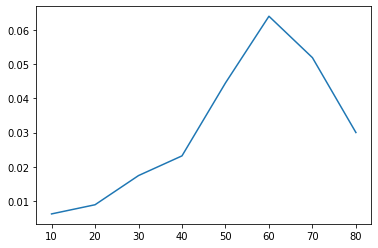

In [165]:
plt.plot(x_axis,kappas,label='pop_algo')

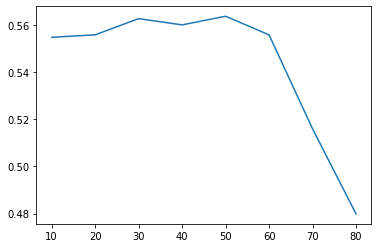

In [162]:
plt.plot(x_axis,accuracies,label='pop_algo')

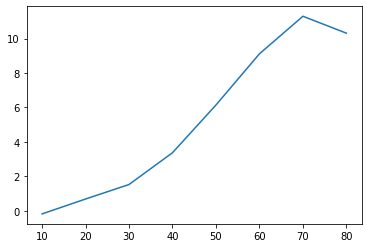

In [163]:
plt.plot(x_axis,pop_biases,label='pop_algo')

In [168]:
tdf=train_df.groupby('song_id')['liked'].mean()

In [171]:
tdf.loc[41]

0.42857142857142855

In [175]:
class PikiPopularityThresholdRecommender:
    
    MODEL_NAME = 'PikiPopularityThreshold'
    
    
    def __init__(self, test_df, train_df,threshold):
        self.test_df = test_df
        self.train_df = train_df
        self.threshold= threshold
        self.songs_by_piki_popularity=train_df.groupby('song_id')['liked'].mean()
        
    def get_model_name(self):
        return self.MODEL_NAME
     
    def classify_items(self, user_id, song_popularity):
        
        recommendations_df = 0*song_popularity
        for ind in recommendations_df.index: 
            try:
                if self.songs_by_piki_popularity[ind]>self.threshold:
                    recommendations_df[ind]=1
                else:
                    recommendations_df[ind]=0   
            except:
                recommendations_df[ind]=0   
        return recommendations_df 



In [177]:
kappas=[]
accuracies=[]
pop_biases=[]
x_axis=(.10,.20,.30,.40,.50,.60,.70,.80,.90)
for i in x_axis:
    piki_threshold_model=PikiPopularityThresholdRecommender(test_df,train_df,i)
    accuracy,kappa,pop_bias,global_metrics,people_metrics=model_evaluator.evaluate_model(piki_threshold_model)
    kappas.append(kappa)
    accuracies.append(accuracy)
    pop_biases.append(pop_bias)
    

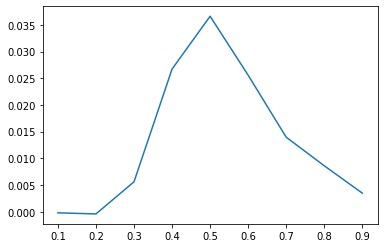

In [178]:
plt.plot(x_axis,kappas,label='piki_algo')

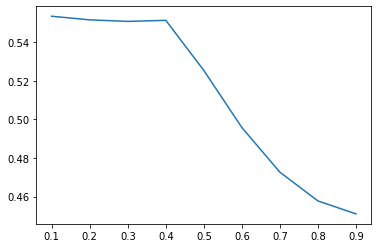

In [179]:
plt.plot(x_axis,accuracies,label='piki_algo')

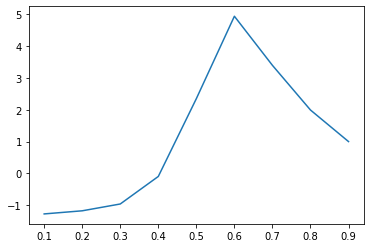

In [180]:
plt.plot(x_axis,pop_biases,label='piki_algo')